In [169]:
#!g1.1

import pandas as pd
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from collections import defaultdict
import torch.utils.data as data
from torch.optim.lr_scheduler import CyclicLR

from IPython.display import clear_output

In [318]:
#!g1.1
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Шифр Цезаря

Учим рекурсивную нейронную сеть расшифровывать текст

### Общие функции

Объявим функции для обучения и отображения кривых

In [338]:
#!g1.1
# Объявим функцию для отображения кривых обучения

def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 5))

    plt.subplot(1,3,1)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()
    
    plt.subplot(1,3,3)
    for scheduler_name in history['lr']:
        plt.plot(history['lr'][scheduler_name], label=scheduler_name)
    plt.ylabel('lr', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()
    
    plt.show()


# Объявим функцию для обучения

def train(
    model,
    criterion,
    optimizer,
    schedulers,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    # История значений точности модели и функции потерь
    history = defaultdict(lambda: defaultdict(list))
    alphabet_length = model.linear.out_features

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm в режим обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).flatten()

            logits, hidden = model(X_batch)
            logits = logits.view(-1, alphabet_length)
    
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            # Применяем LR Schedulers в конце шага
            for scheduler in schedulers.get("batch", []):
                scheduler.step()
        
        # Применяем LR Schedulers в конце эпохи
        for scheduler in schedulers.get("epoch", []):
            scheduler.step()

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        for scheduler in schedulers.get("epoch", []):
            history['lr'][scheduler.__class__.__name__].append(scheduler.get_last_lr())
        for scheduler in schedulers.get("batch", []):
            history['lr'][scheduler.__class__.__name__].append(scheduler.get_last_lr())

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).flatten()

            logits, hidden = model(X_batch)
            logits = logits.view(-1, alphabet_length)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

### Подготавливаем данные

Читаем текст из файла, чистим его и приводим к нижнему регистру. Нарезаем на предложения и формируем из них два датасета: для обучения и валидации

In [172]:
#!g1.1
# Читаем текстовый файл, формируем строку с алфавитом и массив примеров текста

file_path = './karamazov-brothers.txt'
sample_size = 60
caesar_offset = 4

alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '

with open('./karamazov-brothers.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    text = text.lower()
    text = ''.join(filter(lambda x: x in alphabet, text))

text_samples = [text[i:i+sample_size] for i in range(0, len(text), sample_size)][:-1]

In [173]:
#!g1.1
text_samples[0:5], len(text_samples)

(['самый сложный самый многоуровневый и неоднозначный из романо',
  'в достоевского который критики считали то интеллектуальным д',
  'етективом то ранним постмодернизмом то  лучшим из произведен',
  'ий о загадочной русской душе роман легший в основу десятков ',
  'экранизаций  от предельно точных до самых отвлеченных  но не'],
 28666)

In [174]:
#!g1.1
y = torch.tensor([[alphabet.find(ch) for ch in sample] for sample in text_samples]).to(device)
X = torch.tensor([[alphabet.find(ch) + caesar_offset for ch in sample] for sample in text_samples]).to(device)

In [175]:
#!g1.1
dataset = TensorDataset(X, y)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

### Обучаем модель

Сделаем рекуррентную сеть для 24-размерного пространства слов/символов

In [176]:
#!g1.1
class RNN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.embed = torch.nn.Embedding(len(alphabet) + caesar_offset, 32)
        self.rnn = torch.nn.RNN(32, 128)
        self.linear = torch.nn.Linear(128, len(alphabet) + caesar_offset)

    def forward(self, sentence, state=None):
        embed = self.embed(sentence)
        o, h = self.rnn(embed)
        return self.linear(o)

In [177]:
#!g1.1
model = RNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
train_gen = data.DataLoader(train_dataset, batch_size=10, shuffle=True)
val_gen = data.DataLoader(val_dataset, batch_size=10, shuffle=False)

Epoch 10 of 10 took 6.494s
  training loss (in-iteration): 	0.000085
  validation loss (in-iteration): 	0.000080
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


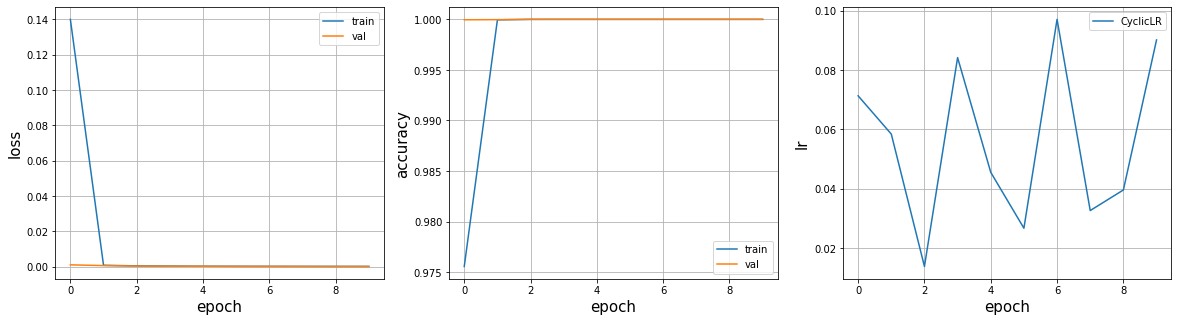

In [178]:
#!g1.1
model, history = train(
    model,
    criterion,
    optimizer,
    {"batch": [CyclicLR(optimizer,0.001,0.1)]},
    train_gen,
    val_gen
)

Видно, что из пушки по воробьям, попробуем упростить сеть

In [179]:
#!g1.1
class RNN_light(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.embed = torch.nn.Embedding(len(alphabet) + caesar_offset, 4)
        self.rnn = torch.nn.RNN(4, 16)
        self.linear = torch.nn.Linear(16, len(alphabet) + caesar_offset)

    def forward(self, sentence, state=None):
        embed = self.embed(sentence)
        o, h = self.rnn(embed)
        return self.linear(o)

In [180]:
#!g1.1
model = RNN_light().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
train_gen = data.DataLoader(train_dataset, batch_size=10, shuffle=True)
val_gen = data.DataLoader(val_dataset, batch_size=10, shuffle=False)

Epoch 10 of 10 took 6.499s
  training loss (in-iteration): 	0.001280
  validation loss (in-iteration): 	0.001174
  training accuracy: 			99.99 %
  validation accuracy: 			100.00 %


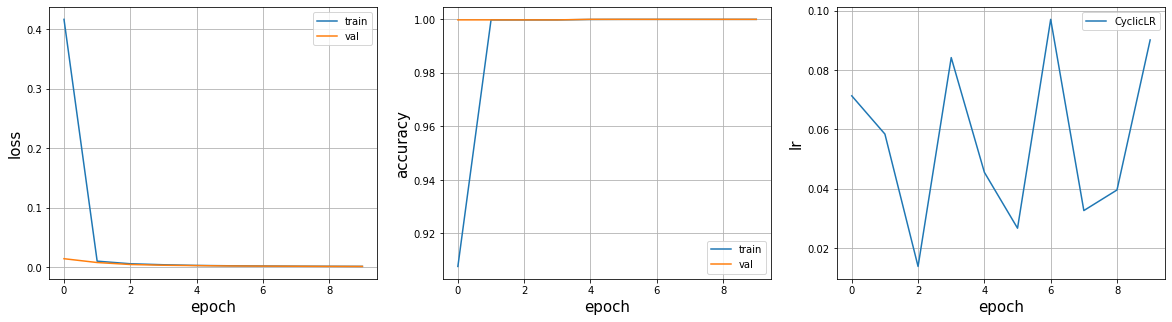

In [181]:
#!g1.1
model, history = train(
    model,
    criterion,
    optimizer,
    {"batch": [CyclicLR(optimizer,0.001,0.1)]},
    train_gen,
    val_gen
)

In [182]:
#!g1.1
sample = "небольшая тестовая строка для проверки"
encrypted_sample_idx = [i + caesar_offset for i in [alphabet.find(char) for char in sample]]
encrypted_sample = "".join([alphabet[i % len(alphabet)] for i in encrypted_sample_idx])

result = model(torch.tensor([encrypted_sample_idx]).to(device)).argmax(dim=2)
decrypted_sample = "".join([alphabet[i.item()] for i in result.flatten()])
print(encrypted_sample)
print(decrypted_sample)

сиетп ьдвгцихцтёдвгхцфтодгзпвгуфтёифом
небольшая тестовая строка для проверки


## 2. Генерация фраз из Симсонов

In [510]:
#!g1.1
# Загружаем данные в DataFrame
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,0,10368,35,29,"Lisa Simpson: Maggie, look. What's that?",235000,True,9,5.0,Lisa Simpson,Simpson Home,"Maggie, look. What's that?",maggie look whats that,4.0
1,1,10369,35,30,Lisa Simpson: Lee-mur. Lee-mur.,237000,True,9,5.0,Lisa Simpson,Simpson Home,Lee-mur. Lee-mur.,lee-mur lee-mur,2.0
2,2,10370,35,31,Lisa Simpson: Zee-boo. Zee-boo.,239000,True,9,5.0,Lisa Simpson,Simpson Home,Zee-boo. Zee-boo.,zee-boo zee-boo,2.0
3,3,10372,35,33,Lisa Simpson: I'm trying to teach Maggie that ...,245000,True,9,5.0,Lisa Simpson,Simpson Home,I'm trying to teach Maggie that nature doesn't...,im trying to teach maggie that nature doesnt e...,24.0
4,4,10374,35,35,"Lisa Simpson: It's like an ox, only it has a h...",254000,True,9,5.0,Lisa Simpson,Simpson Home,"It's like an ox, only it has a hump and a dewl...",its like an ox only it has a hump and a dewlap...,18.0


In [511]:
#!g1.1
# Используем столбец с нормализованным текстом
alphabet = 'abcdefghijklmnopqrstuvwxyz '
phrases = df['normalized_text'].tolist()
text = [[c for c in ph.lower() if c in alphabet] for ph in phrases if type(ph) is str]

In [512]:
#!g1.1
MAX_LEN = 80
text_all = []
for t in text:
    if len(t) >= MAX_LEN:
        text_all.append(t)

In [513]:
#!g1.1
text_all[0][0:10], len(text_all)

(['i', 'm', ' ', 't', 'r', 'y', 'i', 'n', 'g', ' '], 1757)

In [514]:
#!g1.1
# Генерируем набор тензоров с индексами вместо букв

all_samples = []
for i in range(len(text_all)):
    sample = text_all[i]
    for j in range(len(sample) - MAX_LEN):
        all_samples.append([alphabet.find(char) for char in sample[j:j + MAX_LEN]])

In [517]:
#!g1.1
X = torch.tensor(all_samples).to(device)

In [518]:
#!g1.1
len(X), X[0]

(61117,
 tensor([ 8, 12, 26, 19, 17, 24,  8, 13,  6, 26, 19, 14, 26, 19,  4,  0,  2,  7,
         26, 12,  0,  6,  6,  8,  4, 26, 19,  7,  0, 19, 26, 13,  0, 19, 20, 17,
          4, 26,  3, 14,  4, 18, 13, 19, 26,  4, 13,  3, 26, 22,  8, 19,  7, 26,
         19,  7,  4, 26,  1,  0, 17, 13, 24,  0, 17,  3, 26,  8, 26, 22,  0, 13,
         19, 26,  7,  4, 17, 26, 19, 14], device='cuda:0'))

In [644]:
#!g1.1
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embedding = torch.nn.Embedding(len(alphabet), 128)
        self.rnn = torch.nn.RNN(128, 256, 4)
        self.linear = torch.nn.Linear(256, len(alphabet))

    def forward(self, sentences, hidden=None):
        x = self.embedding(sentences)
        x, hidden = self.rnn(x, hidden)
        return self.linear(x), hidden

In [645]:
#!g1.1
model = Network().to(device)

In [646]:
#!g1.1
X_train = X[:, :-1]
y_train = X[:, 1:]

In [647]:
#!g1.1
print('X:', ''.join([alphabet[ind.item()] for ind in X_train[0].flatten()]))
print('y:', ''.join([alphabet[ind.item()] for ind in y_train[0].flatten()]))

X: im trying to teach maggie that nature doesnt end with the barnyard i want her t
y: m trying to teach maggie that nature doesnt end with the barnyard i want her to


In [648]:
#!g1.1
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=.05)

dataset = TensorDataset(X_train, y_train)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])
train_gen = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
val_gen = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)

Epoch 20 of 20 took 5.686s
  training loss (in-iteration): 	2.360908
  validation loss (in-iteration): 	2.362187
  training accuracy: 			26.68 %
  validation accuracy: 			26.75 %


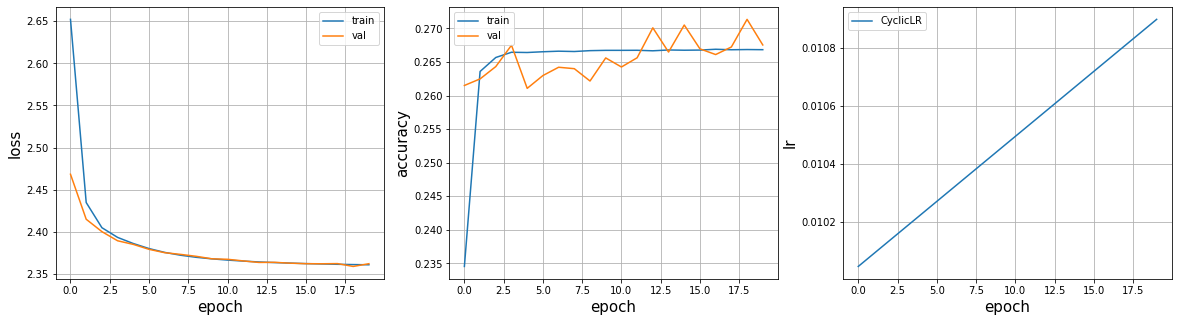

In [649]:
#!g1.1
model, history = train(
    model,
    criterion,
    optimizer,
    {"epoch": [CyclicLR(optimizer,0.01,0.1)]},
    train_gen,
    val_gen,
    20
)

In [652]:
#!g1.1

def generate_sentence(initial_string, length):
    hidden = torch.zeros(4, 256).to(device)
    initial_input = [alphabet.find(char) for char in list(initial_string)]
    predicted = initial_string
    
    for i in range(len(initial_string) - 1):
        _, hidden = model.forward(torch.tensor([initial_input[i]]).to(device), hidden)
    inp = initial_input[-1:]
    
    for i in range(length):
        output, hidden = model.forward(torch.tensor(inp).to(device), hidden)
        
        probas, indices = output.topk(1)
        predicted_char = alphabet[indices.flatten()[-1].item()]
        predicted += predicted_char
        inp = [alphabet.find(predicted_char)]

    return predicted

In [654]:
#!g1.1
generate_sentence('hello', 100)

'hellour t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t'